# **SMILearn**

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mateuszrezler/smilearn/blob/master/demo.ipynb)
<br/>
This notebook is an example study showing how to construct and customize scikit-learn pipelines using SMILearn objects.  
<br/>
*Submitted in March 2020 in partial fulfilment of the requirements for completion of [Kodołamacz Data Science Bootcamp](https://www.kodolamacz.pl/bootcamp-datascience/).*



## Table of contents
1. Introduction  
&emsp;1.1. Aim of the study
2. Materials and methods  
&emsp;2.1. Prerequisites  
&emsp;&emsp;2.1.1. Installations *(Google Colab only)*  
&emsp;&emsp;2.1.2. Imports  
&emsp;2.2. Constants  
&emsp;2.3. SMILearn package  
&emsp;&emsp;2.2.1. `atom` module  
&emsp;&emsp;2.2.2. `structure` module  
&emsp;&emsp;2.2.3. `pipeline` module  
&emsp;2.4. Dataset  
&emsp;&emsp;2.4.1. Source  
&emsp;&emsp;2.4.2. Exploration of raw data  
&emsp;&emsp;2.4.3. Preprocessing  
&emsp;&emsp;2.4.4. Reference pipeline  
&emsp;&emsp;2.4.5. Alternative pipelines  
&emsp;&emsp;2.4.6. Visualization of feature matrices  
&emsp;2.4. Model  
&emsp;&emsp;2.4.1. Model definition  
&emsp;&emsp;2.4.2. Cross validation  
3. Results and discussion  
4. Conclusion
5. References

## 1. Introduction

### 1.1. Aim of the study

The study aims to find the simplest possible feature matrices, generated from SMILES strings, as inputs for one-dimensional convolutional neural network, without significant loss of the accuracy compared to more complex reference matrix.

### 1.2. SMILES notation

The structure of a chemical compound can be described in a linear form (string) following the rules of the simplified molecular-input line-entry system (SMILES).<sup>[1][2]</sup><br/><br/>
Brief description:
* Atoms are represented by their symbols in square brackets which can be omitted in case of the most common symbols (`B`, `C`, `N`, `O`, `F`, `P`, `S`, `Cl`, `Br`, `I`) when they have default properties. Lower case symbols describe atoms in aromatic rings. By default, hydrogen atoms are not shown explicitly. Their number is calculated from the difference in the number of implicit and explicit bonds.
* Bonds are specified by the symbols:  
`.` - ionic,  
`-` - single,  
`/`, `\` - single up and down respectively (next to a double bond),  
`:` - aromatic (between single and double),  
`=` - double,  
`#` - triple.  
By default, single and aromatic bonds are not shown explicitly.
* Branches are represented by the parentheses.
* Ring connections are specified by the pairs of digit indices.
* Additional symbols inside square brackets describe charge (`+`, `-`) or chirality (`@`, `@@`)
<br/><br/>

**Tab. 1.** Examples of SMILES strings

Compound name | Condensed structural formula | SMILES | Comments
--- | --- | --- | ---
Ethanol | CH<sub>3</sub>CH<sub>2</sub>OH | `CCO` | All atoms have default properties (neutral charge, no chirality, typical valence, etc.),<br/>and are not written in square brackets.<br/>Hydrogen atoms and single bonds can be implict.
Calcium hypochlorite | Ca(ClO)<sub>2</sub> | `[Ca+2].[O-]Cl.[O-]Cl` | Atoms with charges are written in square brackets.<br/>Ionic bonds must be shown but single bonds not.
Silicon dioxide | SiO<sub>2</sub> | `O=[Si]=O` | Silicon is not present in the most common symbols set and must be written in square brackets.<br/>Double bonds must be explicit.
L-Lactonitrile | CH<sub>3</sub>CH(OH)CN | `C[C@@H](O)C#N` | Oxygen atom is inside a branch.<br/>Stereogenic carbon atom is written in square brackets with chiral tag.<br/>Single bonds can be implicit, but triple bond not.
*trans*-Cinnamic acid | C<sub>6</sub>H<sub>6</sub>CHCHCOOH | `c1ccccc1/C=C/C(=O)O` | Ring connection is denoted by a pair of digits.<br/>Carbon atoms in the aromatic ring are written in lower case.<br/>Double, single up and single down bonds must be shown but aromatic bonds not.
<br/><br/>

**Fig. 1.** SMILES generation algorithm  
*Source: https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system*  
![Image of SMILES generation algorithm](https://github.com/mateuszrezler/smilearn/blob/master/img/smiles_gen_alg.png?raw=1)

### 1.3. DeepSMILES notation

DeepSMILES is a variant of SMILES string suited for machine learning models.<sup>[3]</sup> Ring size is indicated by a single integer at closing point, while branches are decoded as multiple closing parentheses whose number is equal to the length of the branch.
<br/><br/>

**Tab. 2.** Examples of DeepSMILES strings

Compound name | SMILES | DeepSMILES | Comments
--- | --- | --- | ---
Tetrahydrofuran | `C1COCC1` | `CCOCC5` | Five-membered ring
Laurolactam | `C1CCCCCC(=O)NCCCCC1` | `CCCCCCC=O)NCCCCC%13` | Thirteen-membered ring
Isopropanol | `CC(O)C` | `CCO)C` | Branch with one atom
Triethylamine | `CCN(CC)CC` | `CCNCC))CC` | Branch with two atoms
Diphenyl ether | `O(c1ccccc1)c2ccccc2` | `Occcccc6))))))cccccc6` | Two six-membered rings and branch with six atoms

## 2. Materials and methods

### 2.1. Prerequisites

#### 2.1.1. Installations *(Google Colab only)*

Installation takes about one minute.

In [1]:
%%capture installation_log
%%time

try:
    from google.colab import output
    from sys import path
    # clone SMILearn repository
    !git clone https://github.com/mateuszrezler/smilearn.git
    # install Miniconda
    !wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
    !bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
    !rm Miniconda3-latest-Linux-x86_64.sh
    # install RDKit
    !conda install -y -c conda-forge rdkit
    # install DeepSMILES unofficial GitHub fork
    !pip install git+git://github.com/mateuszrezler/deepsmiles@master
    path.append('/usr/local/lib/python3.7/site-packages')
    %cd smilearn
    %tensorflow_version 2.x
except ModuleNotFoundError:
    pass

#### 2.1.2. Imports

External

In [2]:
from deepsmiles import Converter as DeepSmilesConverter
from pandas import DataFrame, read_csv, Series
from rdkit.RDLogger import DisableLog
from rdkit.Chem import MolFromSmiles, MolToSmiles
from re import findall
from sklearn.pipeline import FeatureUnion, Pipeline
from numpy import array, mean, std
from numpy.random import seed
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv1D, Dense, \
    GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from json import load as load_json
from os.path import join as path_join

Internal

In [3]:
from smilearn.display.figures import feature_matrix, hide_atoms, molimg
from smilearn.display.tags import BR, arrow_down, b, code, fig, i, p, tab
from smilearn.features.atom import *
from smilearn.features.pipeline import *
from smilearn.features.structure import *
from smilearn.model.tools import compare_tstudent, EpochCounter
from smilearn.reference.feature import mol_to_feature

### 2.2. Constants

Predefined constant values are loaded from `smilearn/config/constants.json` file.  
Hyperparameters for one-dimensional convolutional neural network were optimized with Optuna, an automatic hyperparameter optimization framework.<sup>[4]</sup>

In [4]:
constants_json = path_join('smilearn', 'config', 'constants.json')
with open(constants_json) as cj:
    CONSTANTS = load_json(cj)
for C in CONSTANTS:
    assignment = f'{C.upper()} = {CONSTANTS[C]}'
    exec(assignment)
    print(assignment)

EPOCHS = 16
LAYERS = {'conv1': {'activation': 'elu', 'filters': 64, 'kernel_size': 15, 'padding': 'same', 'strides': 1}, 'pool': {'padding': 'same', 'pool_size': 6, 'strides': 5}, 'conv2': {'activation': 'elu', 'filters': 8, 'kernel_size': 18, 'padding': 'same', 'strides': 3}}
LEARNING_RATE = 0.0001
SEED = 0
VERBOSE = 0


### 2.3. SMILearn package

This section is a short demo of SMILearn package, a toolkit for making feature matrices directly from SMILES strings.  
It consists of three main modules:
1. `atom` - a set of functions extracting specific features from a single atom,
2. `structure` - functions pulling out features directly from SMILES characters,
3. `pipeline` - a collection of transformers implemented to work in scikit-learn pipelines.
<br/><br/>

Adenosine monophosphate magnesium salt (Fig. 2) is an example of complex compound whose SMILES representation is very diverse.  
Making of RDKit Mol object (using RDKit package)<sup>[5]</sup> is needed to explore features of its atoms, bonds, branches and rings.

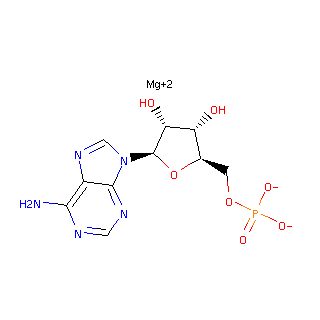

In [5]:
MgAMP_smiles = '[Mg+2].C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H](O3)C\
OP(=O)([O-])[O-])O)O)N'
mol = MolFromSmiles(MgAMP_smiles)
fig(2, 'Adenosine monophospate magnesium salt')
molimg(mol)

#### 2.3.1. `atom` module

Functions availabale in `atom` module:
1. `get_atomic_num` - returns atomic number.
2. `get_charge` - returns formal charge with `shift` value added (set to `0` by default).
3. `get_degree` - returns degree of substitution.
4. `get_group` - returns group number (in periodic table).
5. `get_num_hs` - returns total number of connected hydrogen atoms.
6. `get_period` - returns period number (in periodic table).
7. `get_valence` - returns total valence.
8. `has_chiral_tag` - returns `1.0` when atom has specified chiral tag.
9. `has_hybridization` - returns `1.0` when atom has specified hybridization.
10. `has_no_symbol` - returns `1.0` when atom has none of the symbols given.
11. `has_symbol` - returns `1.0` when atom has one of the symbols given.
12. `is_aromatic` - returns `1.0` when atom is a part of an aromatic ring.
13. `is_in_ring` - returns `1.0` when atom is a part of a ring.
14. `is_metal` - returns `1.0` when atom is metal.
15. `is_metalloid` - returns `1.0` when atom is metalloid.

*Abovementioned functions take two positional arguments (`mol` and `index`).  
By default, they return `float` values. This can be changed by setting `astype` parameter.  
Functions 1-7 return values divided by `maxval` parameter (set to `1` by default).*

All these functions were used in generation of the dataframe (Tab 3). Atom numbering scheme is added for clarity (Fig 3).

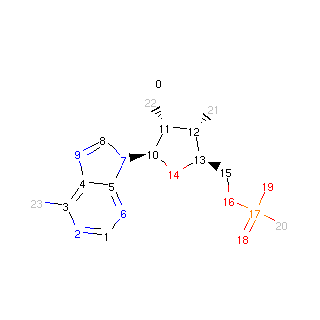

,Symbol,ChiCW,HybSP3,NotCNO,C,Arom,Metal,Metalloid,InRing,AtNum,Charge,Degree/8,Group,NumHs/4,Period,Valence
0,Mg,0.0,0.0,1.0,0,False,True,False,False,12,2,0.000,2,0.00,3,0.0
1,C,0.0,0.0,0.0,1,True,False,False,True,6,0,0.375,14,0.25,2,4.0
2,N,0.0,0.0,0.0,0,True,False,False,True,7,0,0.250,15,0.00,2,3.0
3,C,0.0,0.0,0.0,1,True,False,False,True,6,0,0.375,14,0.00,2,4.0
4,C,0.0,0.0,0.0,1,True,False,False,True,6,0,0.375,14,0.00,2,4.0
5,C,0.0,0.0,0.0,1,True,False,False,True,6,0,0.375,14,0.00,2,4.0
6,N,0.0,0.0,0.0,0,True,False,False,True,7,0,0.250,15,0.00,2,3.0
7,N,0.0,0.0,0.0,0,True,False,False,True,7,0,0.375,15,0.00,2,3.0
8,C,0.0,0.0,0.0,1,True,False,False,True,6,0,0.375,14,0.25,2,4.0
9,N,0.0,0.0,0.0,0,True,False,False,True,7,0,0.250,15,0.00,2,3.0


In [6]:
fig(3, 'Atom numbering of MgAMP (first twenty atoms highlighted)')
molimg(mol, highlightMap=hide_atoms(range(20, 25)), includeAtomNumbers=True)
tab(3, 'Features of the first twenty atoms of MgAMP')
atoms = []
for index in range(20):
    atoms.append([])
    atoms[index].extend([mol.GetAtomWithIdx(index).GetSymbol(),
                         has_chiral_tag('CHI_TETRAHEDRAL_CW')(mol, index),
                         has_hybridization('SP3')(mol, index),
                         has_no_symbol(['C', 'N'], astype=float)(mol, index),
                         has_symbol('C', astype=int)(mol, index),
                         is_aromatic(astype=bool)(mol, index),
                         is_metal(astype=bool)(mol, index),
                         is_metalloid(astype=bool)(mol, index),
                         is_in_ring(astype=bool)(mol, index),
                         get_atomic_num(astype=int)(mol, index),
                         get_charge(astype=int, shift=0)(mol, index),
                         get_degree(maxval=8)(mol, index),
                         get_group(astype=int)(mol, index),
                         get_num_hs(astype=float, maxval=4)(mol, index),
                         get_period(astype=int)(mol, index),
                         get_valence()(mol, index)])
display(DataFrame(
    atoms,
    columns=['Symbol', 'ChiCW', 'HybSP3', 'NotCNO', 'C', 'Arom',
             'Metal', 'Metalloid', 'InRing', 'AtNum', 'Charge',
             'Degree/8', 'Group', 'NumHs/4', 'Period', 'Valence']))

#### 2.3.2. `structure` module

Functions availabale in `structure` module:
1. `get_branch_len` - returns number of consecutive closing parentheses in DeepSMILES string.
2. `get_ring_int` - returns ring closure integer.
3. `is_char` - returns `1.0` when character is exactly as specified.

*These functions take one positional argument (`token`).  
By default, they return `float` values. This can be changed by setting `astype` parameter.  
Functions 1-2 return values divided by `maxval` parameter (set to `1` by default).*

All these functions were used to extract structural features from DeepSmiles representation of MgAMP, shown below, in form of dataframe (Tab. 4).

In [7]:
dsc = DeepSmilesConverter(branches=True, rings=True)
smiles = MolToSmiles(mol, allHsExplicit=True, canonical=False)
deep_smiles = dsc.encode(smiles)
tokens = findall(r'\[.+?\]|\)+|.', deep_smiles)
struct_tokens = [token for token in tokens if token[0] != '[']
p(b('Exemplary preparation steps of structural tokens'), BR*2)
p(i('SMILES with all hydrogens explicit: '), code(smiles), arrow_down())
p(i('DeepSMILES: '), code(deep_smiles), arrow_down())
p(i('Tokens: '), code(tokens), arrow_down())
p(i('Structural tokens: '), code(struct_tokens))
tab(4, 'Structural features extracted from DeepSMILES notation of MgAMP')
tokens = []
for index, token in enumerate(struct_tokens):
    tokens.append([])
    tokens[index].extend([token,
                         get_branch_len(astype=float, maxval=10)(token),
                         get_ring_int(astype=int)(token)])
display(DataFrame(tokens, columns=['Token', 'BranchLen/10', 'RingInt']))

,Token,BranchLen/10,RingInt
0,.,0.0,0
1,),0.1,0
2,6,0.0,6
3,),0.1,0
4,),0.1,0
5,),0.1,0
6,=,0.0,0
7,),0.1,0
8,),0.1,0
9,)))),0.4,0


#### 2.3.3. `pipeline` module

Following classes are availabale in `pipeline` module.  
These transformers are fully compatible with scikit-learn pipelines and implement fit and transform methods.  
Their usage is shown in sections 2.3.4 and 2.3.5.
1. `PipelineTransformer` - base class, for inheritance only.
2. `FunctionApplier` - general dataframe function applier.  
Parameters:  
`function` - function to be applied,  
`astype=Series` - type of the output (dataframe or series).
3. `SeriesSelector` - selects a chosen series from dataframe.  
Parameters:
`series` - series to be selected.
4. `ToArrayConverter` - converts a dataframe to an array.
5. `ZerosFiller` - fills empty cells with zeros.
6. `DeepSmilesEncoder` - converts SMILES to DeepSMILES.  
Parameters:  
`branches=True` - convert branches if True,  
`rings=True` - convert rings if True.
7. `RegexTokenizer` - tokenizes strings using regular expression.  
Parameters:  
`regex='.'` - expression for tokenization.
8. `RingTagInserter` - inserts ring tags in place of integer ring indices.  
Parameters:  
`regex=r'%\d+|[H\+\-]\d\]|.'` - expression differentiating ring numbers from other parts of the SMILES string,  
`reuse=True` - reuse ring digits if true,  
`tags='<>'` - pair of characters used as ring tags.  
9. `SmilesFeaturizer` - builds feature matrices from a given SMILES string and preprocessed tokens.  
Parameters:  
`atom_functions` - list of featurizing functions from `atom` module,  
`struct_functions` - list of featurizing functions from `structure` module,  
`smiles_column=0` - name of a column in the input dataframe with SMILES string convertable to Mol,  
`tokens_column=1` - name of a column in the input dataframe with preprocessed tokens,  
`atom_regex=r'\[.+?\]|Br|Cl|.'` - expression separating atoms from structural elements,  
`h_vector=False` - use simplified hydrogen vector if True,
`max_len=100` - maximum length of tokens,  
`pad_len=0` - length of zero padding before and after a feature matrix.  
10. `SmilesRebuilder` - rebuilds SMILES string,  
for parameters see [RDKit documentation](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html).

### 2.4. Dataset

#### 2.4.1. Source

MoleculeNet website provides a benchmark datasets, models and results for molecular machine learning.<sup>[6]</sup> A single task from Tox21 dataset (NR-AR) is chosen in this study. Tox21 contains qualitative (binary) toxicity measurements on 12 biological targets. NR-AR refers to the results of androgen receptor assay performed on the MDA cell line.

In [8]:
data = read_csv(path_join('smilearn', 'datasets', 'tox21.csv'))

#### 2.4.2. Exploration of raw data

First look at the dataset (Tab. 5) leads to the conclusion that missing values are prevalent.

In [9]:
tab(5, 'First five rows of the dataset')
display(data.head())

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


Analysis of the percentage of positive results unravels highly imbalanced classes. In the case of NR-AR assay, positive results account for almost 4% of all the results obtained. Therefore accuracy is not the metric to use in this situation. According to recommendations found in MoleculeNet, ROC-AUC score is chosen in this study.

In [10]:
num_positives = (data['NR-AR'] == 1).sum()
num_results = data['NR-AR'].shape[0]
perc_positives = num_positives/num_results*100
p('Number of positive results: ', b(num_positives), BR,
  'Number of all results: ', b(num_results), BR,
  'Percentage of positive results: ', b(f'{perc_positives:.1f}%'))

#### 2.4.3. Preprocessing

First step of the preprocessing is the separation of raw features (SMILES strings, `X_raw`) and targets (NR-AR binary activity, `y_raw`).

In [11]:
X_raw = DataFrame(data['smiles'])
y_raw = DataFrame(data['NR-AR'])

Raw targets (`y_raw`) are then cleaned by filling missing data with zeros. Cleaned targets (`y`) in the form of NumPy array are obtained following a simple preprocessing pipeline shown below.

In [12]:
ypipeline = Pipeline([('fill_with_zeros', ZerosFiller()),
                      ('convert_to_array', ToArrayConverter())])
y = ypipeline.fit_transform(y_raw)
p('Shape of targets (y): ', b(y.shape))

#### 2.4.4. Reference pipeline

*Hirohara et al.*<sup>[7]</sup> used one-dimensional convolutional neural networks, trained on SMILES feature matrices, to classify toxicity of compounds from Tox21 dataset.  
The pipeline below is an implementation reproducing accurately their method of featurization. It builds a 400 by 42 feature matrices (`X_ref`) from a set of SMILES strings (`X_raw`). It takes into account all noticed implementation bugs:  
* formal charge non-normalized to 0-1 values (`# 1`),
* columns with no information stored (`# 2`),
* skipping reused ring opening digits (`# 3`),  

and other less explicit mistakes.

In [13]:
# disable RDKit warnings
DisableLog('rdApp.*')

In [14]:
# atom functions
af = [*(has_symbol(symbol) for symbol in 'HCON'),
      has_no_symbol(['H', 'C', 'O', 'N']),
      get_num_hs(maxval=8),
      get_degree(maxval=4),
      get_charge(maxval=8),  # 1
      get_valence(maxval=8),
      is_in_ring(),
      is_aromatic(),
      lambda mol, index: 0,  # 2
      *(has_chiral_tag(f'CHI_TETRAHEDRAL_{tag}') for tag in ('CW', 'CCW')),
      lambda mol, index: 0,  # 2
      *(has_hybridization(hybr) for hybr in ('S', 'SP', 'SP2', 'SP3',
                                             'SP3D', 'SP3D2'))]
# structure functions
sf = [is_char(char) for char in '()[].:=#\\/@+-234567<>']
# rebuilding pipeline
rp = Pipeline([('select_smiles', SeriesSelector('smiles')),
               ('rebuild_smiles', SmilesRebuilder(astype=DataFrame))])
# tokenizing pipeline
tp = Pipeline([('select_smiles', SeriesSelector('smiles')),
               ('build_kekule_smiles',
                SmilesRebuilder(kekuleSmiles=True)),
               ('insert_ring_tags', RingTagInserter(regex=r'%\d+|[\+\-]\d\]|.',
                                                    reuse=False)),  # 3
               ('tokenize_smiles',
                RegexTokenizer(astype=DataFrame, regex=r'[^a-z]'))])
# feature union
fu = FeatureUnion([('rebuilding_pipeline', rp),
                   ('tokenizing_pipeline', tp)])
# featurizing pipeline
fp = Pipeline([('feature_union', fu),
               ('featurize_smiles', SmilesFeaturizer(atom_regex=r'[A-Z]',
                                                     atom_functions=af,
                                                     h_vector=True,
                                                     max_len=400,
                                                     struct_functions=sf))])
X_ref = fp.fit_transform(X_raw)
p('Shape of features (X): ', b(X_ref.shape))

The identity of the output of this pipeline is compared with the output of the reference script.

In [15]:
mols = X_raw['smiles'].apply(MolFromSmiles)
features = mols.apply(lambda mol: mol_to_feature(mol, -1, 400)).to_list()
arr = array(features).astype(float)
ref_df = DataFrame(arr)
X_2d = X_ref.reshape(X_ref.shape[0], -1)
test_df = DataFrame(X_2d)
equal = test_df.equals(ref_df)
p('Outputs are', b(' not'*int(not equal)), b(' equal'), '.')

#### 2.4.5. Alternative pipelines

A part of features from reference feature matrix seems to be redundant. Therefore ten alternative feature matrices with more condensed information encoded are proposed. In the present experiment, gradual steps of dimensionality reduction are appled as follows. Changed fragments of code are denoted with inline comments.

**1<sup>st</sup> alternative pipeline**  
Changes:
* maximum values of numerical data are reduced to more prevalent values (`# 1`),
* formal charge is normalized to 0-1 values (`# 2`),
* columns with no information stored are removed (`# 3`),
* H-vector carrying duplicate information is removed (`# 4`),
* ring opening digits are reused (`# 5`).

Effect:
* Reduction to 358 by 39 matrices.

In [16]:
# atom functions
af1 = [*(has_symbol(symbol) for symbol in 'CON'),
       has_no_symbol(['C', 'O', 'N']),
       get_num_hs(maxval=4),  # 1
       get_degree(maxval=4),
       get_charge(maxval=6, shift=2),  # 1, 2
       get_valence(maxval=4),  # 1
       is_in_ring(),
       is_aromatic(),
       # 3 (removed)
       *(has_chiral_tag(f'CHI_TETRAHEDRAL_{tag}') for tag in ('CW', 'CCW')),
       # 3 (removed)
       *(has_hybridization(hybr) for hybr in ('S', 'SP', 'SP2', 'SP3',
                                              'SP3D', 'SP3D2'))]
# structure functions
sf1 = [is_char(char) for char in '()[].:=#\\/@+-234567<>']
# rebuilding pipeline
rp1 = rp
# tokenizing pipeline
tp1 = Pipeline([('select_smiles', SeriesSelector('smiles')),
                ('build_kekule_smiles', SmilesRebuilder(kekuleSmiles=True)),
                ('insert_ring_tags',
                 RingTagInserter(regex=r'%\d+|[H\+\-]\d\]|.',  # 4
                                 reuse=True)),  # 5
                ('tokenize_smiles',
                 RegexTokenizer(astype=DataFrame, regex=r'[^Ha-z]'))])  # 4
# feature union
fu1 = FeatureUnion([('rebuilding_pipeline', rp1),
                    ('tokenizing_pipeline', tp1)])
# featurizing pipeline
fp1 = Pipeline([('feature_union', fu1),
                ('featurize_smiles',
                 SmilesFeaturizer(atom_regex=r'[A-Z]', atom_functions=af1,
                                  max_len=358, struct_functions=sf1))])  # 4
X_alt1 = fp1.fit_transform(X_raw)
p('Shape of features (X): ', b(X_alt1.shape))

**2<sup>nd</sup> alternative pipeline**  
Changes:
* one-hot encoded atom symbols are reduced to two features (number of group and period in periodic table) (`# 1`),
* one-hot encoded hybridization is removed (it is highly related to degree of substitution and valence and carries potentially duplicate information) (`# 2`),
* potentially non-informative characters (`[]:@+-234567`) are ignored by reduction of input characters for `is_char` function and changing tokenization method (`# 3`).


Effect:
* Reduction to 240 by 19 matrices.

In [17]:
# atom functions
af2 = [get_group(maxval=18),  # 1
       get_period(maxval=6), # 1
       get_num_hs(maxval=8),
       get_degree(maxval=4),
       get_charge(maxval=8, shift=4),
       get_valence(maxval=8),
       is_in_ring(),
       is_aromatic(),
       *(has_chiral_tag(f'CHI_TETRAHEDRAL_{tag}') for tag in ('CW', 'CCW'))]
       # 2 (removed)
# structure functions
sf2 = [is_char(char) for char in '().=#\\/<>']  # 2
# rebuilding pipeline
rp2 = rp1
# tokenizing pipeline
tp2 = Pipeline([('select_smiles', SeriesSelector('smiles')),
                ('build_explicit_smiles',
                 SmilesRebuilder(allHsExplicit=True)),  # 3
                ('insert_ring_tags',
                 RingTagInserter(regex=r'\[.+?\]|%\d+|.',  # 3
                                 reuse=True)),
                ('tokenize_smiles',
                 RegexTokenizer(astype=DataFrame,
                                regex='\[.+?\]|%\d+|[^-:]'))])  # 3
# feature union
fu2 = FeatureUnion([('rebuilding_pipeline', rp2),
                    ('tokenizing_pipeline', tp2)])
# featurizing pipeline
fp2 = Pipeline([('feature_union', fu2),
                ('featurize_smiles',
                 SmilesFeaturizer(atom_regex=r'\[.+?\]',  # 3
                                  atom_functions=af2,
                                  max_len=240,
                                  struct_functions=sf2))])
X_alt2 = fp2.fit_transform(X_raw)
p('Shape of features (X): ', b(X_alt2.shape))

**3<sup>rd</sup> alternative pipeline**  
Changes:
* information about group and period of an element is reduced to atomic number (`# 1`),
* one-hot encoded parentheses are reduced to a single numerical feature (branch length) after conversion to DeepSmiles (`# 2`),
* ring tags encoded as two features are encoded as a single numerical feature (ring size) after conversion to DeepSmiles (`# 3`).



Effect:
* Reduction to 190 by 16 matrices.

In [18]:
# atom functions
af3 = [get_atomic_num(maxval=83),  # 1
       get_num_hs(maxval=8),
       get_degree(maxval=4),
       get_charge(maxval=8, shift=4),
       get_valence(maxval=8),
       is_in_ring(),
       is_aromatic(),
       *(has_chiral_tag(f'CHI_TETRAHEDRAL_{tag}') for tag in ('CW', 'CCW'))]
# structure functions
sf3 = [get_branch_len(maxval=60),
       get_ring_int(maxval=180),
       *(is_char(char) for char in '.=#\\/')]  # 2, 3
# rebuilding pipeline
rp3 = rp2
# tokenizing pipeline
tp3 = Pipeline([('select_smiles', SeriesSelector('smiles')),
                ('build_explicit_smiles',
                 SmilesRebuilder(allHsExplicit=True)),
                ('build_deep_smiles', DeepSmilesEncoder()),  # 2, 3
                ('tokenize_smiles',
                 RegexTokenizer(astype=DataFrame,
                                regex='\[.+?\]|\)+|%\d+|[^-:]'))])  # 2, 3
# feature union
fu3 = FeatureUnion([('rebuilding_pipeline', rp3),
                    ('tokenizing_pipeline', tp3)])
# featurizing pipeline
fp3 = Pipeline([('feature_union', fu3),
                ('featurize_smiles',
                 SmilesFeaturizer(atom_regex=r'\[.+?\]', atom_functions=af3,
                                  max_len=190, struct_functions=sf3))])
X_alt3 = fp3.fit_transform(X_raw)
p('Shape of features (X): ', b(X_alt3.shape))

**Negative control pipeline**  
Changes:
* atomic number is the only information left (`# 1`).

Effect:
* Reduction to 132 by 1 matrices.

In [19]:
# atom functions
afnc = [get_atomic_num(maxval=83)]  # 1
# structure functions
sfnc = []  # 1
# rebuilding pipeline
rpnc = rp3
# tokenizing pipeline
tpnc = Pipeline([('select_smiles', SeriesSelector('smiles')),
                 ('build_explicit_smiles',
                  SmilesRebuilder(allHsExplicit=True)),
                  # 1 (removed)
                 ('tokenize_smiles',
                  RegexTokenizer(astype=DataFrame, regex=r'\[.+?\]'))])  # 1
# feature union
func = FeatureUnion([('rebuilding_pipeline', rpnc),
                     ('tokenizing_pipeline', tpnc)])
# featurizing pipeline
fpnc = Pipeline([('feature_union', func),
                 ('featurize_smiles',
                  SmilesFeaturizer(atom_regex=r'\[.+?\]',
                                   atom_functions=afnc, h_vector=False,
                                   max_len=132, struct_functions=sfnc))])
X_nc = fpnc.fit_transform(X_raw)
p('Shape of features (X): ', b(X_nc.shape))

#### 2.4.6. Visualization of feature matrices

Exemplary feature matrices of a large molecule (teicoplanin A2-1 antibiotc, C<sub>88</sub>H<sub>95</sub>Cl<sub>2</sub>N<sub>9</sub>O<sub>33</sub>, compound 4978, Fig. 4), are visualized as heatmaps (Fig. 5-9).

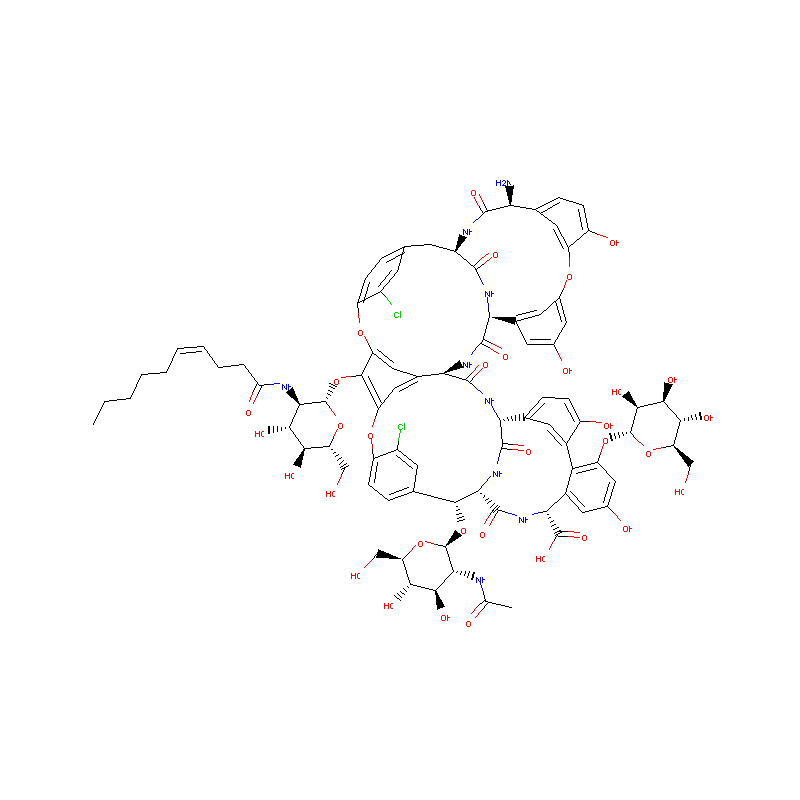

In [20]:
teicoplanin_a2_1 = X_raw['smiles'][4978]
mol = MolFromSmiles(teicoplanin_a2_1)
fig(4, 'Teicoplanin A2-1 (compound 4978)')
molimg(mol, size=(800, 800))

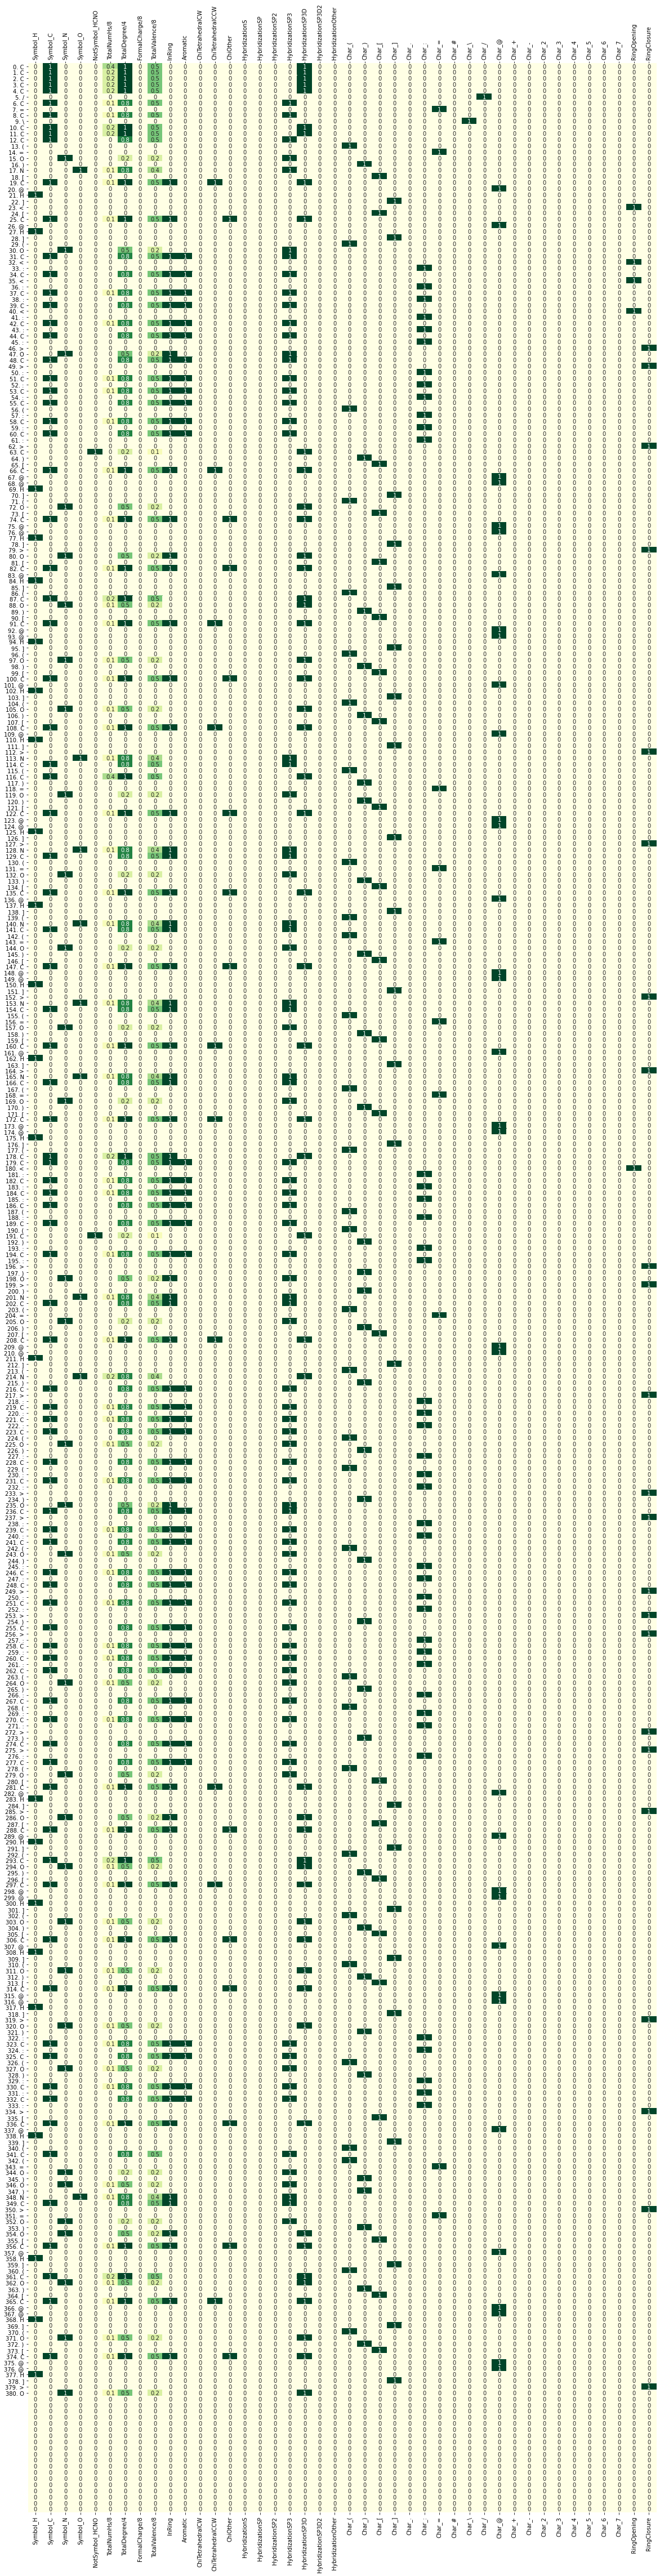

In [21]:
ref_tokens = Series(tp.fit_transform(X_raw)['smiles'])
xlabels = ['Symbol_H', 'Symbol_C', 'Symbol_N', 'Symbol_O', 'NotSymbol_HCNO',
           'TotalNumHs/8', 'TotalDegree/4', 'FormalCharge/8', 'TotalValence/8',
           'InRing', 'Aromatic', 'ChiTetrahedralCW', 'ChiTetrahedralCCW',
           'ChiOther', 'HybridizationS', 'HybridizationSP', 'HybridizationSP2',
           'HybridizationSP3', 'HybridizationSP3D', 'HybridizationSP3D2',
           'HybridizationOther', 'Char_(', 'Char_)', 'Char_[', 'Char_]',
           'Char_.', 'Char_:', 'Char_=', 'Char_#', 'Char_\\', 'Char_/',
           'Char_@', 'Char_+', 'Char_-', 'Char_2', 'Char_3', 'Char_4',
           'Char_5', 'Char_6', 'Char_7', 'RingOpening', 'RingClosure']
fig(5, 'Heatmap of reference feature matrix (400 by 42)')
feature_matrix(X_ref, 4978, 400, size=(20, 80),
               tokens=ref_tokens, xlabels=xlabels)

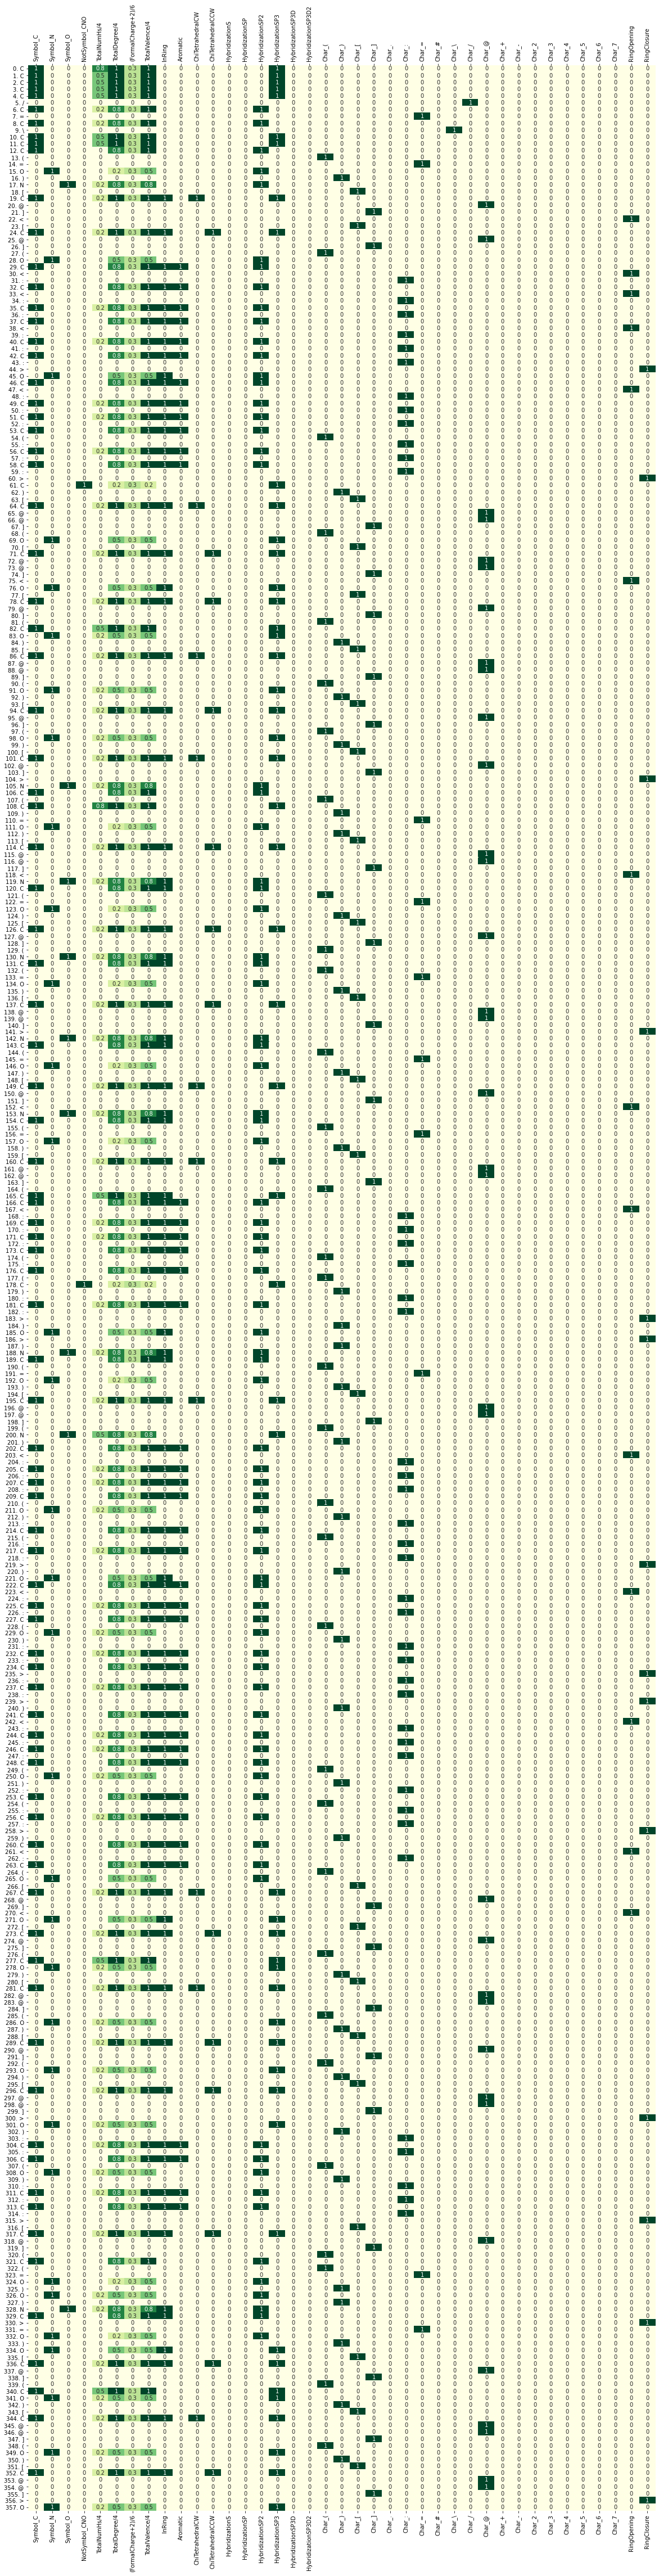

In [22]:
alt1_tokens = Series(tp1.fit_transform(X_raw)['smiles'])
xlabels1 = ['Symbol_C', 'Symbol_N', 'Symbol_O', 'NotSymbol_CNO',
            'TotalNumHs/4', 'TotalDegree/4', '(FormalCharge+2)/6',
            'TotalValence/4', 'InRing', 'Aromatic', 'ChiTetrahedralCW',
            'ChiTetrahedralCCW', 'HybridizationS', 'HybridizationSP',
            'HybridizationSP2', 'HybridizationSP3', 'HybridizationSP3D',
            'HybridizationSP3D2', 'Char_(', 'Char_)', 'Char_[', 'Char_]',
            'Char_.', 'Char_:', 'Char_=', 'Char_#', 'Char_\\', 'Char_/',
            'Char_@', 'Char_+', 'Char_-', 'Char_2', 'Char_3', 'Char_4',
            'Char_5', 'Char_6', 'Char_7', 'RingOpening', 'RingClosure']
fig(6, 'Heatmap of the 1<sup>st</sup> alternative feature matrix (358 by 39)')
feature_matrix(X_alt1, 4978, 358, size=(20, 80),
               tokens=alt1_tokens, xlabels=xlabels1)

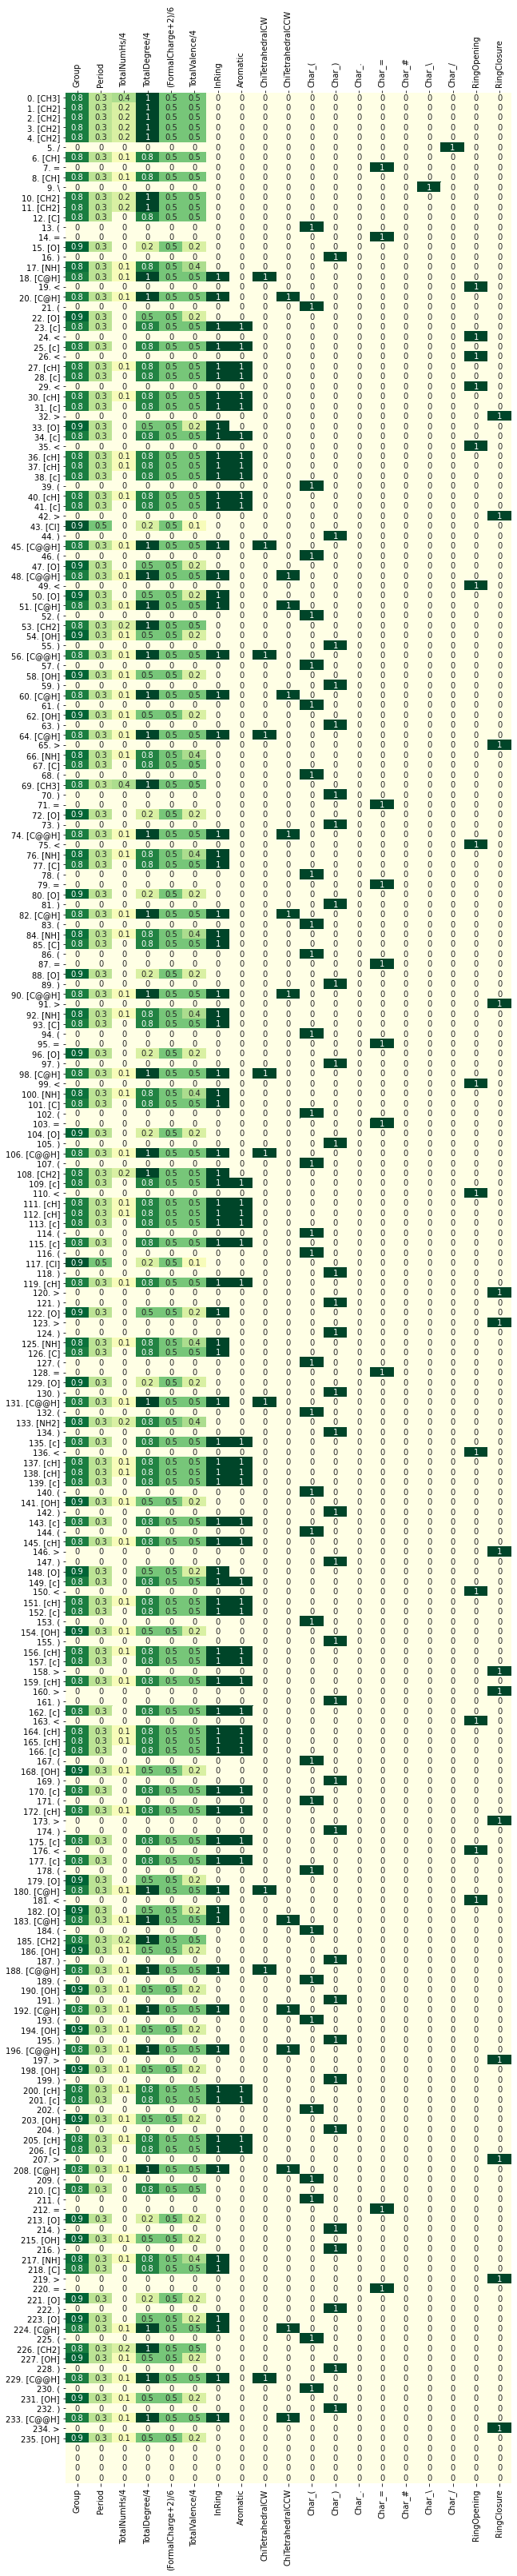

In [23]:
alt2_tokens = Series(tp2.fit_transform(X_raw)['smiles'])
xlabels2 = ['Group', 'Period', 'TotalNumHs/4', 'TotalDegree/4',
            '(FormalCharge+2)/6', 'TotalValence/4', 'InRing', 'Aromatic',
            'ChiTetrahedralCW', 'ChiTetrahedralCCW', 'Char_(', 'Char_)',
            'Char_.', 'Char_=', 'Char_#', 'Char_\\', 'Char_/',
            'RingOpening', 'RingClosure']
fig(7, 'Heatmap of the 2<sup>nd</sup> alternative feature matrix (240 by 19)')
feature_matrix(X_alt2, 4978, 240, size=(10, 55),
               tokens=alt2_tokens, xlabels=xlabels2)

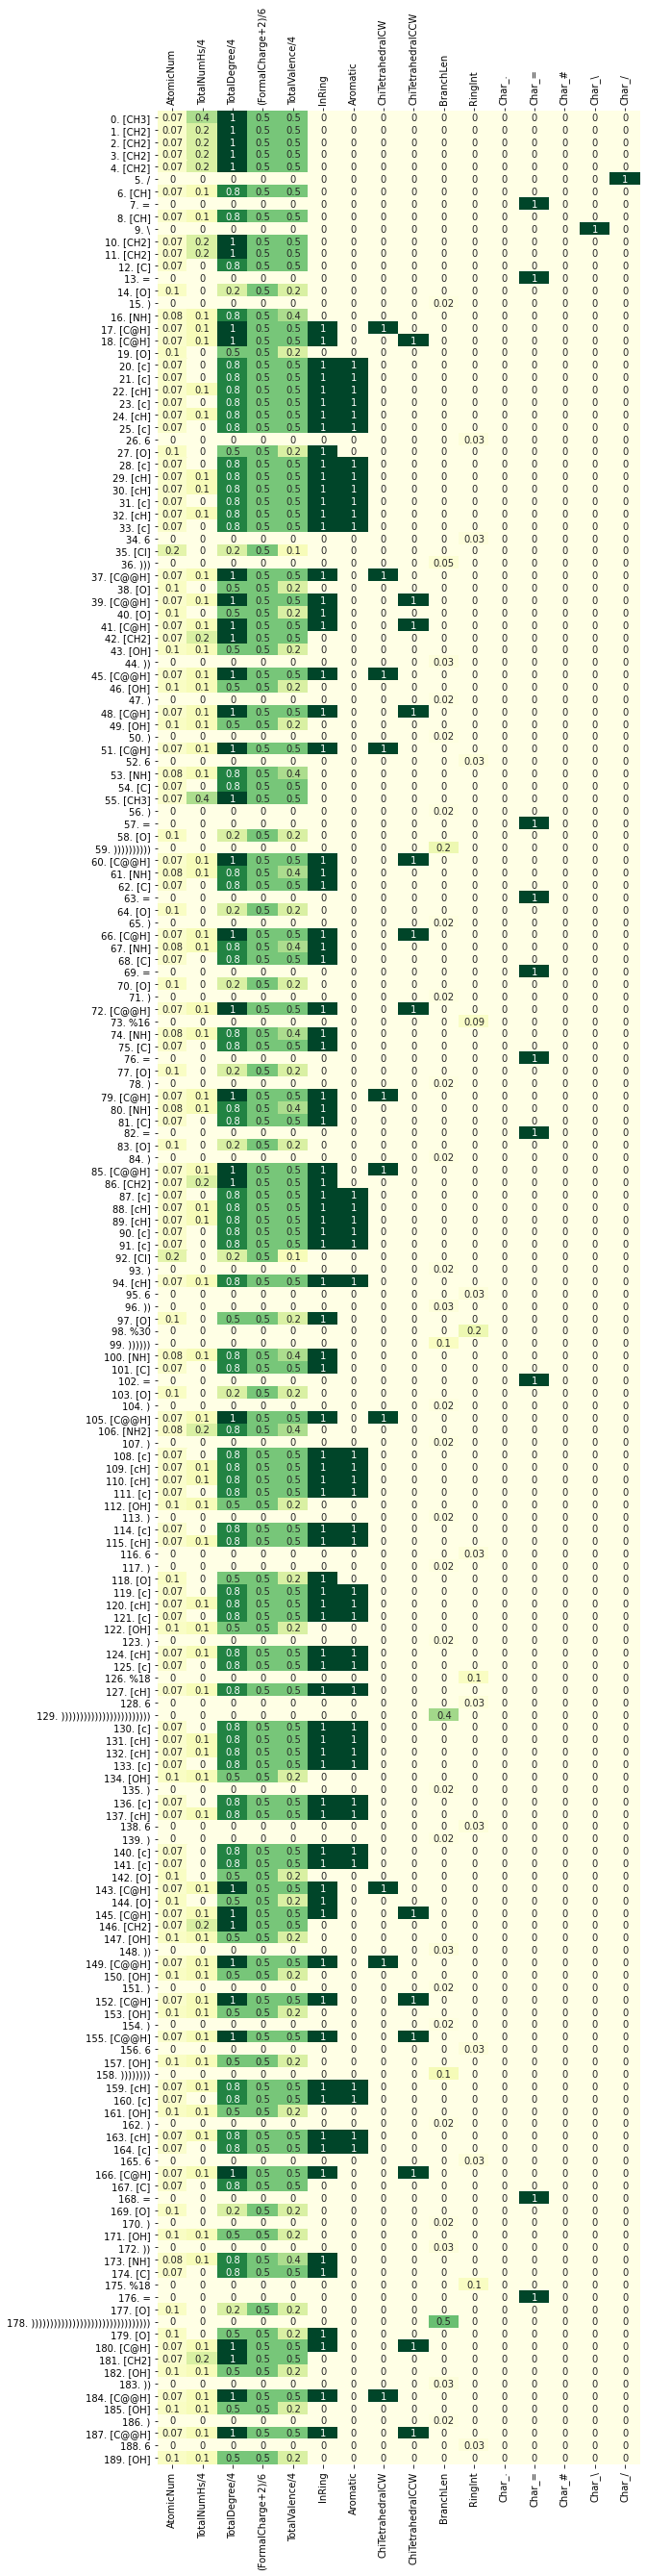

In [24]:
alt3_tokens = Series(tp3.fit_transform(X_raw)['smiles'])
xlabels3 = ['AtomicNum', 'TotalNumHs/4', 'TotalDegree/4', '(FormalCharge+2)/6',
            'TotalValence/4', 'InRing', 'Aromatic', 'ChiTetrahedralCW',
            'ChiTetrahedralCCW', 'BranchLen', 'RingInt', 'Char_.', 'Char_=',
            'Char_#', 'Char_\\', 'Char_/']
fig(8, 'Heatmap of the 3<sup>rd</sup> alternative feature matrix (190 by 16)')
feature_matrix(X_alt3, 4978, 190, size=(9, 45),
               tokens=alt3_tokens, xlabels=xlabels3)

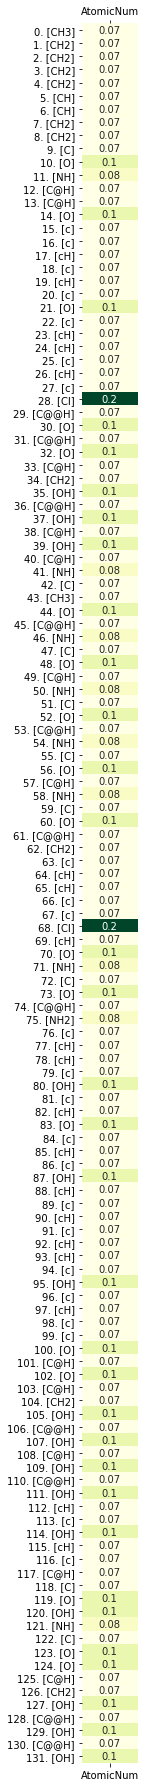

In [25]:
nc_tokens = Series(tpnc.fit_transform(X_raw)['smiles'])
xlabelsnc = ['AtomicNum']
fig(9, 'Heatmap of the negative control feature matrix (132 by 1)')
feature_matrix(X_nc, 4978, 132, size=(1, 32),
               tokens=nc_tokens, xlabels=xlabelsnc)

### 2.5. Model definition

Neural network consisting of two 1D convolution layers with optimized hyperparameters is chosen for further comparisons.

In [26]:
def build_cnn1d(layers, input_shape, learning_rate):
    model = Sequential()
    model.add(Conv1D(**layers['conv1'], input_shape=input_shape))
    model.add(MaxPooling1D(**layers['pool']))
    model.add(Conv1D(**layers['conv2']))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

Mean ROC AUC values are calculated after stratified cross validation defined below.

In [27]:
def run_cv(X, y, build_fn, transformer, layers, input_shape, epochs=10,
           learning_rate=1e-3, n_splits=5, random_seed=0, verbose=1):
    seed(random_seed)
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True,
                             random_state=random_seed)
    fold = 0
    scores = []
    for train, test in skfold.split(X, y):
        fold += 1
        print(f'Fold #{fold}\npreprocessing...', end='')
        X_train = transformer.fit_transform(X.iloc[train,:])
        X_test = transformer.fit_transform(X.iloc[test,:])
        y_train = y[train]
        y_test = y[test]
        ec = EpochCounter()
        model = build_fn(layers, input_shape, learning_rate)
        model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, verbose=verbose, callbacks=[ec])
        predictions = model.predict(X_test)
        score = roc_auc_score(y_test, predictions)
        scores.append(score)
        print(f'score: {score:.4f}'+' '*4)
    msg = f'Mean ROC AUC: {mean(scores):.4f} ({chr(0xB1)} {std(scores):.4f})\n'
    print(msg)
    return scores

## 3. Results and discussion

In the final evaluation, Student's t-test was used to determine if two mean ROC AUC values (alternative and reference) are significantly different from each other.

In [28]:
%%time

scores_ref = run_cv(X_raw, y, build_cnn1d, fp, LAYERS, (400, 42),
                    epochs=EPOCHS, learning_rate=LEARNING_RATE, n_splits=4,
                    random_seed=SEED, verbose=VERBOSE)

Fold #1
score: 0.8493    
Fold #2
score: 0.7968    
Fold #3
score: 0.7660    
Fold #4
score: 0.7873    
Mean ROC AUC: 0.7999 (± 0.0306)

CPU times: user 32min 1s, sys: 33.8 s, total: 32min 35s
Wall time: 17min 37s


In [29]:
%%time

scores_alt1 = run_cv(X_raw, y, build_cnn1d, fp1, LAYERS, (358, 39),
                     epochs=EPOCHS, learning_rate=LEARNING_RATE, n_splits=4,
                     random_seed=SEED, verbose=VERBOSE)
compare_tstudent(scores_ref, scores_alt1)

Fold #1
score: 0.8490    
Fold #2
score: 0.7916    
Fold #3
score: 0.7539    
Fold #4
score: 0.8092    
Mean ROC AUC: 0.8009 (± 0.0342)

The means ARE NOT different with 95% confidence level.

CPU times: user 28min 21s, sys: 47.3 s, total: 29min 9s
Wall time: 15min 53s


In [30]:
%%time

scores_alt2 = run_cv(X_raw, y, build_cnn1d, fp2, LAYERS, (240, 19),
                     epochs=EPOCHS, learning_rate=LEARNING_RATE, n_splits=4,
                     random_seed=SEED, verbose=VERBOSE)
compare_tstudent(scores_ref, scores_alt2)

Fold #1
score: 0.8439    
Fold #2
score: 0.7757    
Fold #3
score: 0.7498    
Fold #4
score: 0.7893    
Mean ROC AUC: 0.7897 (± 0.0344)

The means ARE NOT different with 95% confidence level.

CPU times: user 11min 22s, sys: 22 s, total: 11min 44s
Wall time: 6min 39s


In [31]:
%%time

scores_alt3 = run_cv(X_raw, y, build_cnn1d, fp3, LAYERS, (190, 16),
                     epochs=EPOCHS, learning_rate=LEARNING_RATE, n_splits=4,
                     random_seed=SEED, verbose=VERBOSE)
compare_tstudent(scores_ref, scores_alt3)

Fold #1
score: 0.8352    
Fold #2
score: 0.7798    
Fold #3
score: 0.7509    
Fold #4
score: 0.7887    
Mean ROC AUC: 0.7887 (± 0.0303)

The means ARE NOT different with 95% confidence level.

CPU times: user 8min 1s, sys: 18.4 s, total: 8min 20s
Wall time: 4min 51s


In [32]:
%%time

scores_nc = run_cv(X_raw, y, build_cnn1d, fpnc, LAYERS, (132, 1),
                   epochs=EPOCHS, learning_rate=LEARNING_RATE, n_splits=4,
                   random_seed=SEED, verbose=VERBOSE)
compare_tstudent(scores_ref, scores_nc)

Fold #1
score: 0.6856    
Fold #2
score: 0.6873    
Fold #3
score: 0.7244    
Fold #4
score: 0.7131    
Mean ROC AUC: 0.7026 (± 0.0166)

The means ARE different with 95% confidence level.

CPU times: user 3min 21s, sys: 14.1 s, total: 3min 35s
Wall time: 2min 15s


## 4. Conclusion
According to the tests carried out, a strong reduction of dimensionality from 400 by 42 to 190 by 16 does not harm the predictive power of the neural network being tested. This is only 18% of the data points of the reference solution. Probably there is still a room for further optimization and one may be encouraged to test in-depth the package presented here.

## 5. References

<sup>[1]</sup> https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html  
<sup>[2]</sup> https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system  
<sup>[3]</sup> https://chemrxiv.org/articles/DeepSMILES_An_Adaptation_of_SMILES_for_Use_in_Machine-Learning_of_Chemical_Structures/7097960/1  
<sup>[4]</sup> https://optuna.org/  
<sup>[5]</sup> https://www.rdkit.org/  
<sup>[6]</sup> http://moleculenet.ai/  
<sup>[7]</sup> https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2523-5